In [1]:
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import scipy as sp
import pandas as pd
from netCDF4 import Dataset
import dask
import subprocess

In [2]:
#
# 
#
Expname = 'ControlT124L11'
DataSetname = 'vvel'
Dataname = 'v'
Outputdir = '/Users/bkirtman/Work/AGCM/AGCM/tmp4/'
stamp = 'days_1-900'
dayst = 900
#
#imax = 128 #### T42
#jmax = 64
kmax = 11
#imax = 192 #### T63
#jmax = 96
imax = 376 #### T124
jmax = 188
ijmax = imax*jmax

In [3]:
fps = Outputdir+Expname+'/lnps_1*.nc' # always need surface pressure
dps = xarray.open_mfdataset(fps,decode_times=True, parallel=True)
#
#
fdata = Outputdir+Expname+'/'+DataSetname+'_1*.nc'
ddata = xarray.open_mfdataset(fdata,decode_times=True, parallel=True)

In [4]:
fps

'/Users/bkirtman/Work/AGCM/AGCM/tmp4/ControlT124L11/lnps_1*.nc'

In [5]:
dps

<xarray.Dataset>
Dimensions:  (time: 900, lat: 188, lon: 376)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1952-06-18
  * lat      (lat) float64 -89.27 -88.32 -87.37 -86.42 ... 87.37 88.32 89.27
  * lon      (lon) float64 0.0 0.9574 1.915 2.872 ... 356.2 357.1 358.1 359.0
Data variables:
    lnps     (time, lat, lon) float64 dask.array<chunksize=(30, 188, 376), meta=np.ndarray>

In [6]:
def sigma_to_press(din,ps,lev,kmax):
    din = np.flip(din,axis=0)
    dout = np.zeros((11,jmax,imax)) # '11' here is the manditory pressure levels
    lev = np.flip(lev,axis=0)
    surfp = (np.exp(ps))*1000.0
    plev = [1000.0,900.0,800.0,700.0,600.0,500.0,400.0,300.0,200.0,100.0,20.0]
    #
    # make plev, press, isiglev, press_up, press_down in to arrays so no loops over i & j
    plevR15 = np.zeros((11,jmax,imax))
    for k in range(11):
        plevR15[k,:,:] = plev[k]
    #
    #
    # Find the appropriate pressure level
    #
    found = np.zeros((11,jmax,imax))
    data_up = np.zeros((11,jmax,imax))
    data_dn = np.zeros((11,jmax,imax))
    press_up = np.zeros((11,jmax,imax))
    press_dn = np.zeros((11,jmax,imax))
    for kk in range(11): # "11" here is the number of output pressure levels
        for kkk in range(kmax-1):
            sigp_up = (lev[kkk+1].values)*(surfp.values)
            sigp_dn = (lev[kkk].values)*(surfp.values)
            isiglev_up = ( sigp_up < plevR15[kk] )
            isiglev_dn = ( sigp_dn > plevR15[kk] )
            isiglev_up = 1*isiglev_up
            isiglev_dn = 1*isiglev_dn
            check = ((isiglev_up + isiglev_dn) == 2)
            check = (1*check) + found[kk]
            check = ( check == 1)
            check = 1*check
            found[kk] = check*kkk + (1-check)*found[kk]
        #
        for kkk in range(kmax-1):
            sigp_up = (lev[kkk+1].values)*(surfp.values)
            sigp_dn = (lev[kkk].values)*(surfp.values)
            check = (found[kk] == kkk)
            check = 1*check
            data_up[kk] = check*din[kkk+1]+(1-check)*data_up[kk]
            data_dn[kk] = check*din[kkk]+(1-check)*data_dn[kk]
            press_up[kk] = check*sigp_up+(1-check)*press_up[kk]
            press_dn[kk] = check*sigp_dn+(1-check)*press_dn[kk]
        #
    #
    press_up = np.where(press_up <= 0.0, 0.1, press_up)
    press_dn = np.where(press_dn <= 0.0, 0.1, press_dn)
    tmp1 = np.zeros((11,jmax,imax))
    for kk in range(11):
        xup = np.log(plevR15[kk]) - np.log(press_dn[kk])
        xdn = np.log(press_up[kk]) - np.log(press_dn[kk])
        yup = np.log(press_up[kk]) - np.log(plevR15[kk])
        tmp = ((xup/xdn)*data_up[kk])+((yup/xdn)*data_dn[kk])
        check = (found[kk] > 0)
        check = 1*check
        tmp1[kk] = check
        dout[kk] = check*tmp + (1-check)*dout[kk]
#        dout[kk] = np.where(check <= 0.0, None, dout[kk]) # This sets below surface to
                                                          # undefined
    #
    for k in range(9): ### if below ground use lowest sigma level
        dout[k] = tmp1[k]*dout[k] + (1-tmp1[k])*din[0].values
    #
    return dout

In [7]:
#
# Create Data Array for Control Pressure level Data geopotenial, temp, u & v
# 
#
#
#
tmp = (dayst,11,jmax,imax) #### "11" here corresponds to standard pressure levels not to model levels
dout = np.zeros(tmp)
siglevs = ddata['lev']
for k in range (dayst):
    vv = ddata[Dataname][k,:,:,:]
    ps = dps.lnps[k,:,:]
    vv = vv.compute()
    ps = ps.compute()
    dout[k] = sigma_to_press(vv,ps,siglevs,kmax)
lats = ddata['lat'].values
lons = ddata['lon'].values
plev = [1000.0,900.0,800.0,700.0,600.0,500.0,400.0,300.0,200.0,100.0,20.0]
times = ddata['time']
dData = xarray.Dataset({Dataname: (['time','lev','lat','lon'],dout)},
                        coords={'time': times,'lev':plev, 'lat': lats, 'lon': lons})

In [8]:
dData

<xarray.Dataset>
Dimensions:  (time: 900, lev: 11, lat: 188, lon: 376)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1952-06-18
  * lev      (lev) float64 1e+03 900.0 800.0 700.0 ... 300.0 200.0 100.0 20.0
  * lat      (lat) float64 -89.27 -88.32 -87.37 -86.42 ... 87.37 88.32 89.27
  * lon      (lon) float64 0.0 0.9574 1.915 2.872 ... 356.2 357.1 358.1 359.0
Data variables:
    v        (time, lev, lat, lon) float64 8.604 8.582 8.557 ... 1.844 1.81

In [9]:
dData.to_netcdf(Outputdir+Expname+'/'+DataSetname+'_Pressure_'+stamp+'.nc')

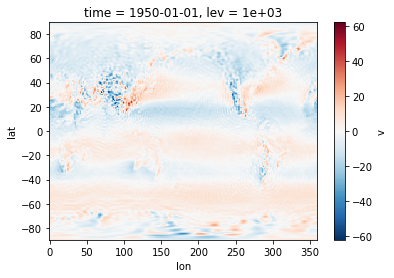

In [10]:
dData[Dataname][0,0,:,:].plot()

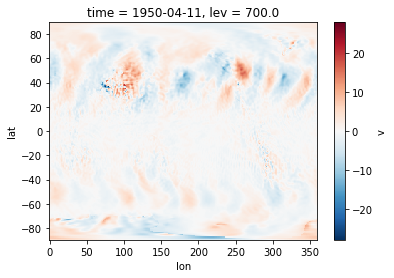

In [11]:
dData[Dataname][100,3,:,:].plot()

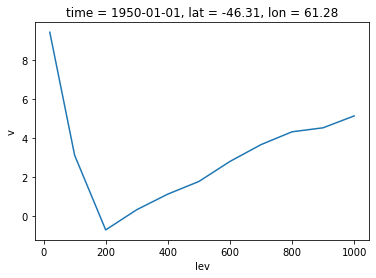

In [12]:
dData[Dataname][0,:,45,64].plot()